##  データを取得

##  都道府県別魅力度ランキング　そしてDBに保存

In [7]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time

# SQLiteのデータベースを作成または接続
conn = sqlite3.connect('prefectures.db')
cursor = conn.cursor()

# 既存テーブルを削除
cursor.execute('DROP TABLE IF EXISTS prefecture_ranking;')

# 都道府県ランキングを格納するテーブルを1つ作成
cursor.execute('''
CREATE TABLE prefecture_ranking (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    prefecture_name TEXT UNIQUE,
    ranking INTEGER,
    point TEXT
);
''')

# データを取得するURL
Prefectural_att = "https://uub.jp/pdr/s/m.html"

# URLからデータを取得
request = requests.get(Prefectural_att)
request.encoding = 'utf-8'

# BeautifulSoupでHTMLを解析
soup = BeautifulSoup(request.text, 'html.parser')

# trタグを全て取得
tr_tags = soup.find_all('tr')
seen_prefectures = set()
previous_rank = None

# データベースにデータを挿入
for tr in tr_tags:
    td_tags = tr.find_all('td')

    if len(td_tags) == 3:
        # ランキングの取得
        rank = td_tags[0].get_text(strip=True)

        # 空のrankを前回のrankで埋める
        if rank == "":
            rank = previous_rank

        # 都道府県名の取得
        prefecture = td_tags[1].get_text(strip=True)
        # 魅力度（点数）の取得
        point = td_tags[2].get_text(strip=True)

        # "編集管理ページへ" を除外する条件を追加
        if prefecture == "" or prefecture == "編集管理ページへ":
            continue

        # 重複していない都道府県名のみ処理
        if prefecture not in seen_prefectures:
            print(f"Ranking: {rank}, Prefecture: {prefecture}, Point: {point}")

            # 都道府県とランキング情報を1つのテーブルに挿入
            cursor.execute('''
            INSERT OR IGNORE INTO prefecture_ranking (prefecture_name, ranking, point)
            VALUES (?, ?, ?);
            ''', (prefecture, rank, point))

            seen_prefectures.add(prefecture)

        # 前回のランキングを保存
        previous_rank = rank

        # サーバーに負担をかけないために0.5秒の遅延を追加
        time.sleep(0.5)

# データベースの変更をコミット
conn.commit()

# データベース接続を閉じる
conn.close()


Ranking: 1, Prefecture: 北海道, Point: 72.4
Ranking: 2, Prefecture: 京都府, Point: 56.6
Ranking: 3, Prefecture: 沖縄県, Point: 52.7
Ranking: 4, Prefecture: 東京都, Point: 49.0
Ranking: 5, Prefecture: 大阪府, Point: 43.3
Ranking: 6, Prefecture: 福岡県, Point: 40.4
Ranking: 7, Prefecture: 神奈川県, Point: 39.4
Ranking: 8, Prefecture: 奈良県, Point: 37.2
Ranking: 9, Prefecture: 石川県, Point: 33.4
Ranking: 10, Prefecture: 長崎県, Point: 32.3
Ranking: 11, Prefecture: 宮城県, Point: 32.2
Ranking: 12, Prefecture: 千葉県, Point: 32.1
Ranking: 13, Prefecture: 長野県, Point: 31.9
Ranking: 14, Prefecture: 静岡県, Point: 30.6
Ranking: 14, Prefecture: 兵庫県, Point: 30.6
Ranking: 16, Prefecture: 愛知県, Point: 29.1
Ranking: 17, Prefecture: 広島県, Point: 26.5
Ranking: 18, Prefecture: 熊本県, Point: 26.3
Ranking: 19, Prefecture: 鹿児島県, Point: 26.1
Ranking: 20, Prefecture: 青森県, Point: 25.2
Ranking: 21, Prefecture: 山梨県, Point: 24.5
Ranking: 22, Prefecture: 富山県, Point: 23.8
Ranking: 23, Prefecture: 宮崎県, Point: 23.7
Ranking: 24, Prefecture: 三重県, Point: 23.2

## 都道府県ごとの観光者数を取得　そしてDBに保存

In [28]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time

# SQLiteデータベースに接続
conn = sqlite3.connect('foreigners.db')
cursor = conn.cursor()

# テーブルがすでに存在している場合は削除し、再作成
cursor.execute('DROP TABLE IF EXISTS prefecture_foreigners;')

# 観光客データを格納するテーブルを作成
cursor.execute('''
CREATE TABLE prefecture_foreigners (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    prefecture_name TEXT,
    ranking INTEGER,
    number TEXT
);
''')

# 外国人観光客数を取得するURL
Tourist_count_Foreigners = "https://eleminist.com/article/3778"

# URLからデータを取得
request_Foreigners = requests.get(Tourist_count_Foreigners)
request_Foreigners.encoding = 'utf-8'

# BeautifulSoupでHTMLを解析
soup_Foreigners = BeautifulSoup(request_Foreigners.text, 'html.parser')

# tbodyタグを取得
tbody = soup_Foreigners.find('tbody')
seen_prefectures = set()
previous_rank = None

# データをデータベースに挿入または更新
for tr in tbody.find_all('tr'):
    td_tags = tr.find_all('td')

    if len(td_tags) == 3:
        # ランキングの取得
        rank_F = td_tags[0].get_text(strip=True)
        if rank_F == "":
            rank_F = previous_rank

        # 都道府県名の取得
        prefecture_F = td_tags[1].get_text(strip=True)
        # 観光客数（number）の取得
        number_F = td_tags[2].get_text(strip=True)

        # "全国" や "編集管理ページへ" を除外する条件を追加
        if prefecture_F == "" or prefecture_F == "全国" or prefecture_F == "編集管理ページへ":
            continue

        # 重複していない都道府県名のみ処理
        if prefecture_F not in seen_prefectures:
            print(f"Ranking: {rank_F}, Prefecture: {prefecture_F}, Number: {number_F}")

            # 観光客データをprefecture_foreignersテーブルに挿入
            cursor.execute('''
            INSERT INTO prefecture_foreigners (prefecture_name, ranking, number)
            VALUES (?, ?, ?);
            ''', (prefecture_F, rank_F, number_F))

            seen_prefectures.add(prefecture_F)

        # 前回のランキングを保存
        previous_rank = rank_F

        # サーバーに負担をかけないために0.5秒の遅延を追加
        time.sleep(0.5)

# データベースの変更をコミット
conn.commit()

# データベース接続を閉じる
conn.close()


Ranking: １, Prefecture: 東京都, Number: 42,727,680
Ranking: ２, Prefecture: 大阪府, Number: 18,480,840
Ranking: 3, Prefecture: 京都府, Number: 12,119,590
Ranking: 4, Prefecture: 北海道, Number: 6,775,200
Ranking: 5, Prefecture: 福岡県, Number: 4,737,990
Ranking: 6, Prefecture: 沖縄県, Number: 4,148,110
Ranking: 7, Prefecture: 千葉県, Number: 3,241,150
Ranking: 8, Prefecture: 神奈川県, Number: 2,665,810
Ranking: 9, Prefecture: 愛知県, Number: 1,984,390
Ranking: 10, Prefecture: 長野県, Number: 1,417,120
Ranking: 11, Prefecture: 山梨県, Number: 1,325,830
Ranking: 12, Prefecture: 広島県, Number: 1,292,470
Ranking: 13, Prefecture: 大分県, Number: 1,281,000
Ranking: 14, Prefecture: 岐阜県, Number: 1,108,050
Ranking: 15, Prefecture: 石川県, Number: 1,034,530
Ranking: 16, Prefecture: 静岡県, Number: 1,027,640
Ranking: 17, Prefecture: 兵庫県, Number: 1,024,830
Ranking: 18, Prefecture: 熊本県, Number: 961,870
Ranking: 19, Prefecture: 宮城県, Number: 518,330
Ranking: 20, Prefecture: 和歌山県, Number: 494,300
Ranking: 21, Prefecture: 長崎県, Number: 461,970
Rank

## ジャラーンからそれぞれの都道府県ごとの観光地データを取得する

In [36]:
import requests
from bs4 import BeautifulSoup
import time
import sqlite3

# SQLiteデータベースに接続（なければ新しく作成されます）
conn = sqlite3.connect('jalan_db.db')
cursor = conn.cursor()

# テーブルが既に存在する場合は削除
cursor.execute('DROP TABLE IF EXISTS jalan_pre_data')

# 新しくテーブルを作成（必要なカラムを含めて）
cursor.execute('''
CREATE TABLE IF NOT EXISTS jalan_pre_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    prefecture_name TEXT,
    tourism_title TEXT,
    review TEXT,
    comment_counts INTEGER,
    travel_type_child INTEGER DEFAULT 0,
    travel_type_couple INTEGER DEFAULT 0,
    travel_type_friend INTEGER DEFAULT 0,
    travel_type_senior INTEGER DEFAULT 0,
    travel_type_solo INTEGER DEFAULT 0
)
''')

# Step 1: `main_url` からリンクを収集する部分
main_url = 'https://www.jalan.net/kankou/?ccnt=global_navi'

# Webページを取得
response = requests.get(main_url)
response.encoding = response.apparent_encoding  # エンコーディングを適切に設定

# BeautifulSoupでHTMLを解析
soup = BeautifulSoup(response.text, 'html.parser')

# <div id="mapArea" class="has-han">内の<dd>タグと<dt>タグを検索
map_area = soup.find('div', {'id': 'mapArea'})  # id="mapArea"を持つdivを検索
dd_tags = map_area.find_all('dd')  # <dd>タグを取得

# リストにURLを保存
urls_to_scrape = []

# 北海道の情報を追加
hokkaido_div = soup.find('div', {'class': 'hokkaido'})  # class="hokkaido"のdivを検索
if hokkaido_div:
    a_tag = hokkaido_div.find('a')  # <div class="hokkaido">内の<a>タグを検索
    if a_tag:
        href = a_tag.get('href')  # href属性を取得
        if href:  # hrefが存在する場合のみ追加
            full_url = 'https://www.jalan.net' + href
            urls_to_scrape.append(full_url)
            print(f"Found Hokkaido URL: {full_url}")

# 取得した<dd>タグ内の<a>タグのhrefをリストに追加
for dd_tag in dd_tags:
    a_tag = dd_tag.find('a')  # <dd>タグ内の<a>タグを検索
    if a_tag:
        href = a_tag.get('href')  # href属性を取得
        if href:  # hrefが存在する場合のみ追加
            full_url = 'https://www.jalan.net' + href
            urls_to_scrape.append(full_url)

# 沖縄の情報を追加
okinawa_div = soup.find('div', {'class': 'okinawa'})  # class="okinawa"のdivを検索
if okinawa_div:
    a_tag = okinawa_div.find('a')  # <div class="okinawa">内の<a>タグを検索
    if a_tag:
        href = a_tag.get('href')  # href属性を取得
        if href:  # hrefが存在する場合のみ追加
            full_url = 'https://www.jalan.net' + href
            urls_to_scrape.append(full_url)
            print(f"Found Okinawa URL: {full_url}")

# リストに保存したURLを確認
print(f"収集したリンク: {urls_to_scrape}")

# Step 2: 各リンク先で施設情報を収集する部分
max_page = 8  # 最大ページ数を1〜15に設定

total_facilities = 0  # 施設数をカウントする変数

# 各リンクを順に処理
for link in urls_to_scrape:
    print(f"処理中: {link}")

    # 都道府県ごとに1ページ目から15ページ目までループ
    for page_num in range(1, max_page + 1):
        page_url = f"{link}?page={page_num}"  # ページ番号を付け加える
        print(f"ページ取得中: {page_url}")

        # ページを取得
        response = requests.get(page_url)
        response.encoding = response.apparent_encoding  # エンコーディングを適切に設定
        soup = BeautifulSoup(response.text, 'html.parser')

        # 現在の都道府県名を取得（h1タグから）
        h1_tag = soup.find('h1', {'class': 'contentTitle'})
        if h1_tag:
            prefecture_name = h1_tag.text.strip()  # 都道府県名を取得
            print(f"現在取得中の都道府県: {prefecture_name}")

        # 'item-info'クラスを持つdivタグを取得
        div_tags = soup.find_all('div', {'class': 'item-info'})

        # リスト内のリンク先（施設ページ）のhref属性を取得
        urls_to_scrape_inner = []
        for div_tag in div_tags:
            a_tags = div_tag.find_all('a')  # divタグ内のaタグをすべて取得
            for a_tag in a_tags:
                href_value = a_tag.get('href')  # href属性を取得
                if href_value and 'kuchikomi' not in href_value:  # 'kuchikomi'が含まれていない場合のみ
                    full_url = 'https:' + href_value  # 完全なURLに変換
                    urls_to_scrape_inner.append(full_url)
        time.sleep(0.5)  # 0.5秒のスリープ（サーバーに負荷をかけないように）

        # 各リンク先（施設ページ）で情報を取得
        for idx, kankou_data in enumerate(urls_to_scrape_inner, start=1):
            total_facilities += 1  # 施設数をカウント
            print(f"処理中: {kankou_data} (施設 {total_facilities})")

            # 施設ページを取得
            response = requests.get(kankou_data)
            response.encoding = response.apparent_encoding  # エンコーディングを適切に設定
            soup = BeautifulSoup(response.text, 'html.parser')

            # タイトル（h1タグ）
            h1_tag = soup.find('h1', {'class': 'detailTitle'})
            title = f"{h1_tag.text.strip()}" if h1_tag else "タイトル情報なし"

            # レビュー評価（spanタグ）
            R_span_tag = soup.find('span', {'class': 'reviewPoint'})
            if R_span_tag:
                review_point = R_span_tag.text.strip()  # 評価をそのまま取得
                # 小数点を含む数字だけを抽出
                review_point = ''.join([char for char in review_point if char.isdigit() or char == '.'])
            else:
                review_point = "レビュー評価なし"

            # 口コミ数（spanタグ内のbタグ）
            C_span_tag = soup.find('span', {'class': 'reviewCount'})  # まず、spanタグを探します
            review_count = "口コミ数なし"
            if C_span_tag:
                b_tag = C_span_tag.find('b')  # spanタグ内のbタグを探します
                if b_tag:
                    review_count = ''.join([char for char in b_tag.text.strip() if char.isdigit()])

            # タグ情報（ulタグ内のliタグ）
            ul_tags = soup.find_all('ul', {'class': 'detailHeader-tags'})
            tags = []
            if ul_tags:
                for li_tag in ul_tags:
                    li_tags = li_tag.find_all('li')
                    for li in li_tags:
                        tags.append(f"  - {li.text.strip()}")  # 各タグをリストに追加
            tags_output = "タグ情報: " + ", ".join(tags) if tags else "タグ情報なし"

            # 旅行タイプ別評価を取得
            travel_type_list = {'child': 0, 'couple': 0, 'friend': 0, 'senior': 0, 'solo': 0}
            travel_type_graph = soup.find_all('div', {'class': 'reviewRatingGraph__item'})  # 旅行タイプ別評価の情報を取得
            if travel_type_graph:
                for item in travel_type_graph:
                    travel_type_label = item.find('dt')  # 旅行タイプ（子連れ、カップルなど）
                    travel_type_rating = item.find('span', {'class': 'reviewPoint'})  # 評価
                    if travel_type_label and travel_type_rating:
                        label = travel_type_label.text.strip()
                        rating = travel_type_rating.text.strip()
                        if "子連れ" in label:
                            travel_type_list['child'] = rating
                        elif "カップル" in label:
                            travel_type_list['couple'] = rating
                        elif "友達" in label:
                            travel_type_list['friend'] = rating
                        elif "シニア" in label:
                            travel_type_list['senior'] = rating
                        elif "一人旅" in label:
                            travel_type_list['solo'] = rating

            # jalan_pre_dataテーブルに施設情報を追加
            cursor.execute('''
            INSERT INTO jalan_pre_data (prefecture_name, tourism_title, review, comment_counts, 
                    travel_type_child, travel_type_couple, travel_type_friend, 
                    travel_type_senior, travel_type_solo)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (prefecture_name, title, review_point, review_count,
                  travel_type_list['child'], travel_type_list['couple'], travel_type_list['friend'],
                  travel_type_list['senior'], travel_type_list['solo']))

            # コミットしてデータベースに保存
            conn.commit()


        # 各ページの情報取得後に0.5秒のスリープを入れる
        time.sleep(0.01)

# 最後に総施設数を出力
print(f"総施設数: {total_facilities}")

# データベースを閉じる
conn.close()


Found Hokkaido URL: https://www.jalan.net/kankou/010000/
Found Okinawa URL: https://www.jalan.net/kankou/470000/
収集したリンク: ['https://www.jalan.net/kankou/010000/', 'https://www.jalan.net/kankou/020000/', 'https://www.jalan.net/kankou/030000/', 'https://www.jalan.net/kankou/040000/', 'https://www.jalan.net/kankou/050000/', 'https://www.jalan.net/kankou/060000/', 'https://www.jalan.net/kankou/070000/', 'https://www.jalan.net/kankou/130000/', 'https://www.jalan.net/kankou/140000/', 'https://www.jalan.net/kankou/110000/', 'https://www.jalan.net/kankou/120000/', 'https://www.jalan.net/kankou/100000/', 'https://www.jalan.net/kankou/080000/', 'https://www.jalan.net/kankou/090000/', 'https://www.jalan.net/kankou/150000/', 'https://www.jalan.net/kankou/160000/', 'https://www.jalan.net/kankou/170000/', 'https://www.jalan.net/kankou/180000/', 'https://www.jalan.net/kankou/190000/', 'https://www.jalan.net/kankou/200000/', 'https://www.jalan.net/kankou/230000/', 'https://www.jalan.net/kankou/210000/

##  それぞれの観光地ごとの平均値、標準偏差、総数などなどを出力

Ranking: １, Prefecture: 東京都, Number: 42,727,680
Ranking: ２, Prefecture: 大阪府, Number: 18,480,840
Ranking: 3, Prefecture: 京都府, Number: 12,119,590
Ranking: 4, Prefecture: 北海道, Number: 6,775,200
Ranking: 5, Prefecture: 福岡県, Number: 4,737,990
Ranking: 6, Prefecture: 沖縄県, Number: 4,148,110
Ranking: 7, Prefecture: 千葉県, Number: 3,241,150
Ranking: 8, Prefecture: 神奈川県, Number: 2,665,810
Ranking: 9, Prefecture: 愛知県, Number: 1,984,390
Ranking: 10, Prefecture: 長野県, Number: 1,417,120
Ranking: 11, Prefecture: 山梨県, Number: 1,325,830
Ranking: 12, Prefecture: 広島県, Number: 1,292,470
Ranking: 13, Prefecture: 大分県, Number: 1,281,000
Ranking: 14, Prefecture: 岐阜県, Number: 1,108,050
Ranking: 15, Prefecture: 石川県, Number: 1,034,530
Ranking: 16, Prefecture: 静岡県, Number: 1,027,640
Ranking: 17, Prefecture: 兵庫県, Number: 1,024,830
Ranking: 18, Prefecture: 熊本県, Number: 961,870
Ranking: 19, Prefecture: 宮城県, Number: 518,330
Ranking: 20, Prefecture: 和歌山県, Number: 494,300
Ranking: 21, Prefecture: 長崎県, Number: 461,970
Rank

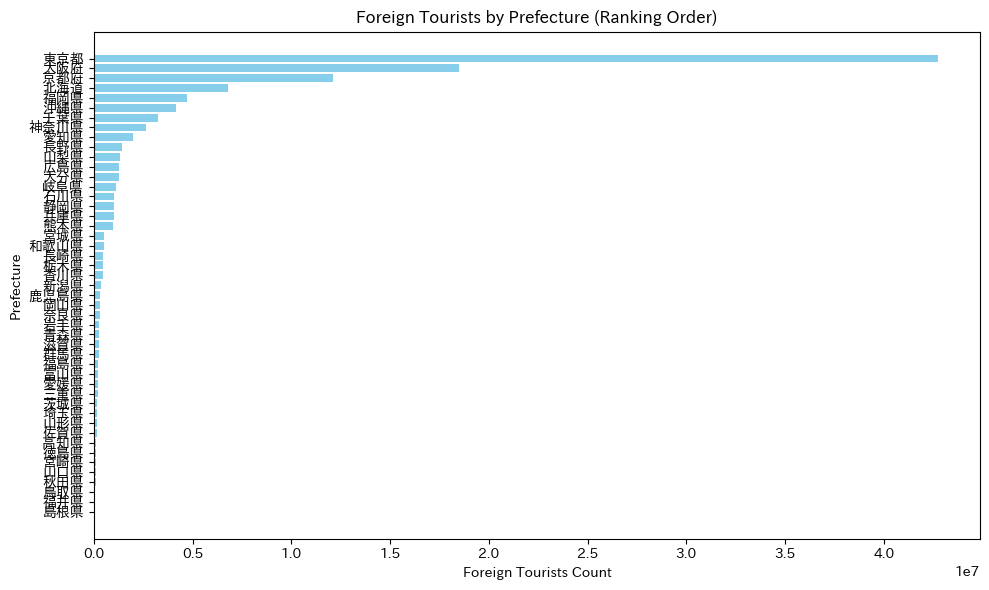

In [43]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np  # 標準偏差を計算するために追加

# SQLiteデータベースに接続
conn = sqlite3.connect('foreigners.db')
cursor = conn.cursor()

# テーブルがすでに存在している場合は削除し、再作成
cursor.execute('DROP TABLE IF EXISTS prefecture_foreigners;')

# 観光客データを格納するテーブルを作成
cursor.execute('''
CREATE TABLE prefecture_foreigners (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    prefecture_name TEXT,
    ranking INTEGER,
    number TEXT
);
''')

# 外国人観光客数を取得するURL
Tourist_count_Foreigners = "https://eleminist.com/article/3778"

# URLからデータを取得
request_Foreigners = requests.get(Tourist_count_Foreigners)
request_Foreigners.encoding = 'utf-8'

# BeautifulSoupでHTMLを解析
soup_Foreigners = BeautifulSoup(request_Foreigners.text, 'html.parser')

# tbodyタグを取得
tbody = soup_Foreigners.find('tbody')
seen_prefectures = set()
previous_rank = None

# データをデータベースに挿入または更新
for tr in tbody.find_all('tr'):
    td_tags = tr.find_all('td')

    if len(td_tags) == 3:
        # ランキングの取得
        rank_F = td_tags[0].get_text(strip=True)
        if rank_F == "":
            rank_F = previous_rank

        # 都道府県名の取得
        prefecture_F = td_tags[1].get_text(strip=True)
        # 観光客数（number）の取得
        number_F = td_tags[2].get_text(strip=True)

        # "全国" や "編集管理ページへ" を除外する条件を追加
        if prefecture_F == "" or prefecture_F == "全国" or prefecture_F == "編集管理ページへ":
            continue

        # 重複していない都道府県名のみ処理
        if prefecture_F not in seen_prefectures:
            print(f"Ranking: {rank_F}, Prefecture: {prefecture_F}, Number: {number_F}")

            # 観光客データをprefecture_foreignersテーブルに挿入
            cursor.execute('''
            INSERT INTO prefecture_foreigners (prefecture_name, ranking, number)
            VALUES (?, ?, ?);
            ''', (prefecture_F, rank_F, number_F))

            seen_prefectures.add(prefecture_F)

        # 前回のランキングを保存
        previous_rank = rank_F

        # サーバーに負担をかけないために0.5秒の遅延を追加
        time.sleep(0.5)

# データベースの変更をコミット
conn.commit()

# 外国人観光客数を取得（並べ替えせずに挿入順に取得）
cursor.execute('SELECT prefecture_name, number FROM prefecture_foreigners')
rows = cursor.fetchall()

# 観光客数のリスト
prefecture_names = []
tourist_numbers = []

# 各都道府県のデータをリストに格納
for row in rows:
    prefecture_names.append(row[0])
    number_str = row[1].replace(',', '')  # カンマを削除
    try:
        tourist_numbers.append(int(number_str))  # 整数に変換
    except ValueError:
        tourist_numbers.append(0)  # 数値変換できなかった場合は0

# 総外国人観光客数の計算
total_foreigners = sum(tourist_numbers)

# 平均外国人観光客数の計算
average_foreigners = np.mean(tourist_numbers)

# 標準偏差の計算
standard_deviation = np.std(tourist_numbers)

# 結果を表示
print(f"総外国人観光客数: {total_foreigners}")
print(f"平均外国人観光客数: {average_foreigners:.2f}")
print(f"標準偏差: {standard_deviation:.2f}")

# 棒グラフをプロット
plt.figure(figsize=(10, 6))  # グラフのサイズを設定
plt.barh(prefecture_names, tourist_numbers, color='skyblue')  # 横棒グラフ
plt.xlabel('Foreign Tourists Count')  # X軸のラベル
plt.ylabel('Prefecture')  # Y軸のラベル
plt.title('Foreign Tourists by Prefecture (Ranking Order)')  # グラフのタイトル
plt.gca().invert_yaxis()  # ランキング順に表示するためY軸を反転
plt.tight_layout()  # レイアウトを調整

# グラフを表示
plt.show()

# データベース接続を閉じる
conn.close()


都道府県ごとの平均レビュー評価、平均口コミ数、口コミ数の合計:
沖縄の観光スポット: 平均レビュー評価 = 4.653333333333333, 平均口コミ数 = 351.8, 口コミ数の合計 = 84432
宮崎の観光スポット: 平均レビュー評価 = 4.4, 平均口コミ数 = 364.3666666666667, 口コミ数の合計 = 87448
福岡の観光スポット: 平均レビュー評価 = 4.36, 平均口コミ数 = 673.8666666666667, 口コミ数の合計 = 161728
愛媛の観光スポット: 平均レビュー評価 = 4.339583333333334, 平均口コミ数 = 443.82916666666665, 口コミ数の合計 = 106519
熊本の観光スポット: 平均レビュー評価 = 4.286666666666666, 平均口コミ数 = 465.8333333333333, 口コミ数の合計 = 111800
滋賀の観光スポット: 平均レビュー評価 = 4.25875, 平均口コミ数 = 133.98333333333332, 口コミ数の合計 = 32156
香川の観光スポット: 平均レビュー評価 = 4.25, 平均口コミ数 = 354.6333333333333, 口コミ数の合計 = 85112
鹿児島の観光スポット: 平均レビュー評価 = 4.24, 平均口コミ数 = 427.9, 口コミ数の合計 = 102696
埼玉の観光スポット: 平均レビュー評価 = 4.2299999999999995, 平均口コミ数 = 108.34761904761905, 口コミ数の合計 = 22753
山口の観光スポット: 平均レビュー評価 = 4.2125, 平均口コミ数 = 456.475, 口コミ数の合計 = 109554
長崎の観光スポット: 平均レビュー評価 = 4.208333333333333, 平均口コミ数 = 657.1125, 口コミ数の合計 = 157707
徳島の観光スポット: 平均レビュー評価 = 4.198333333333333, 平均口コミ数 = 196.1375, 口コミ数の合計 = 47073
千葉の観光スポット: 平均レビュー評価 = 4.19375, 平均口コミ数 = 1484.9833333333333, 口コミ

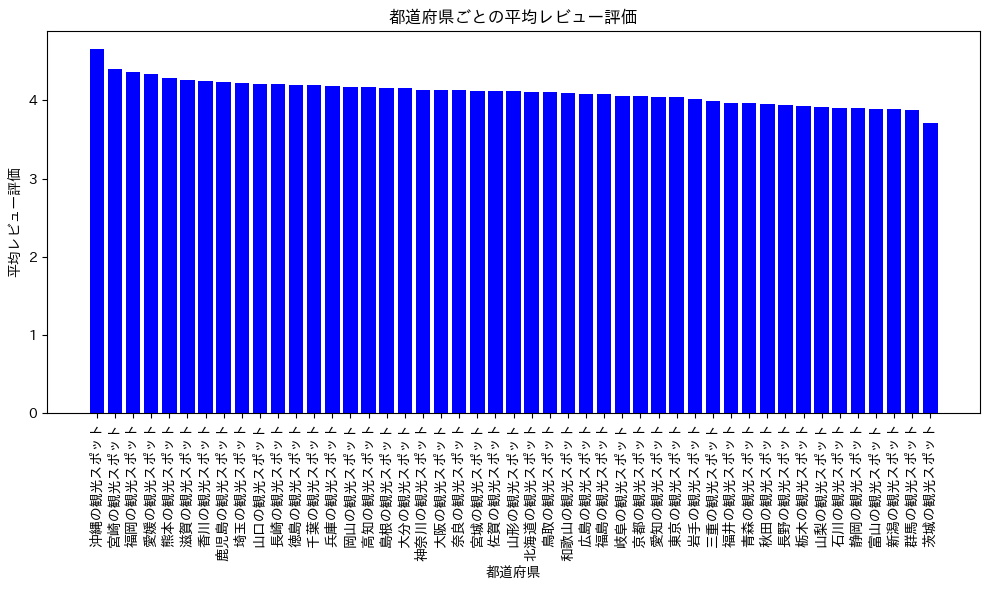

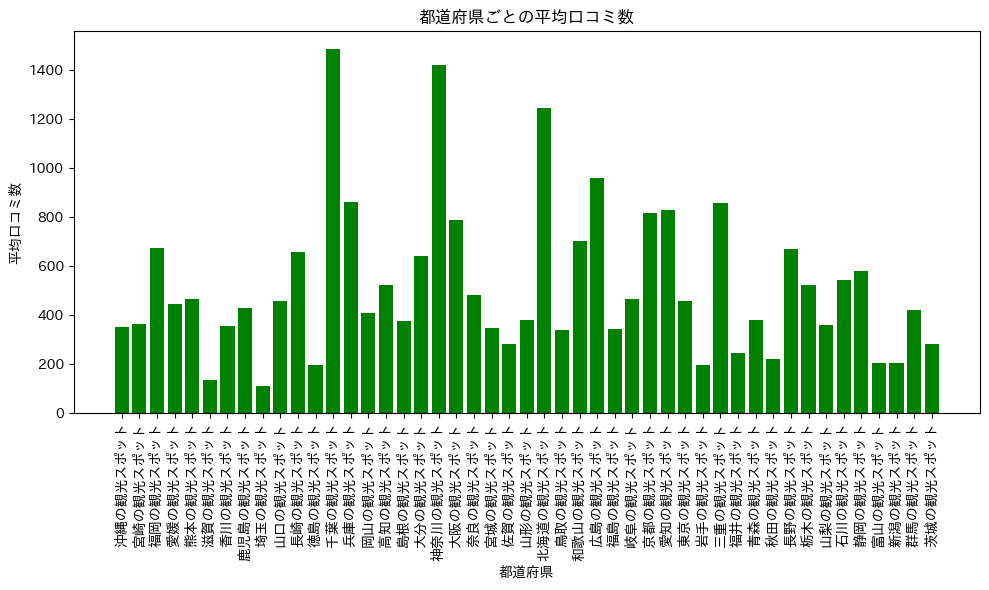

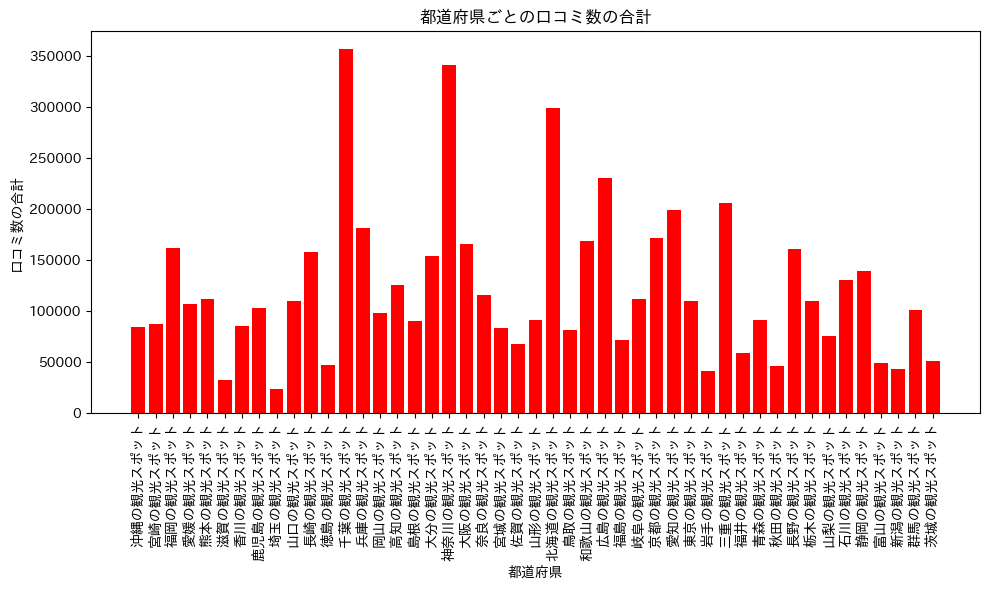

In [45]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# SQLiteデータベースに接続
conn = sqlite3.connect('jalan_db.db')
cursor = conn.cursor()

# 都道府県ごとの平均レビュー評価、口コミ数の平均、口コミ数の合計を計算
cursor.execute('''
SELECT prefecture_name, 
       AVG(CAST(review AS REAL)) AS avg_review, 
       AVG(CAST(comment_counts AS REAL)) AS avg_comment_count,
       SUM(CAST(comment_counts AS INTEGER)) AS total_comment_count
FROM jalan_pre_data
GROUP BY prefecture_name
ORDER BY avg_review DESC
''')

# 結果を取得
rows = cursor.fetchall()

# データを処理
prefecture_names = [row[0] for row in rows]
avg_reviews = [row[1] for row in rows]
avg_comment_counts = [row[2] for row in rows]
total_comment_counts = [row[3] for row in rows]

# データベース接続を閉じる
conn.close()

# print関数でデータを表示
print("都道府県ごとの平均レビュー評価、平均口コミ数、口コミ数の合計:")
for i in range(len(prefecture_names)):
    print(f"{prefecture_names[i]}: 平均レビュー評価 = {avg_reviews[i]}, "
          f"平均口コミ数 = {avg_comment_counts[i]}, 口コミ数の合計 = {total_comment_counts[i]}")

# グラフを作成

# 1. 都道府県ごとの平均レビュー評価のグラフ
plt.figure(figsize=(10, 6))
plt.bar(prefecture_names, avg_reviews, color='b')
plt.xlabel('都道府県')
plt.ylabel('平均レビュー評価')
plt.title('都道府県ごとの平均レビュー評価')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. 都道府県ごとの平均口コミ数のグラフ
plt.figure(figsize=(10, 6))
plt.bar(prefecture_names, avg_comment_counts, color='g')
plt.xlabel('都道府県')
plt.ylabel('平均口コミ数')
plt.title('都道府県ごとの平均口コミ数')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. 都道府県ごとの口コミ数の合計のグラフ
plt.figure(figsize=(10, 6))
plt.bar(prefecture_names, total_comment_counts, color='r')
plt.xlabel('都道府県')
plt.ylabel('口コミ数の合計')
plt.title('都道府県ごとの口コミ数の合計')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##  相関係数の計算

都道府県ごとの平均レビュー評価、平均口コミ数、口コミ数の合計:
沖縄の観光スポット: 平均レビュー評価 = 4.653333333333333, 平均口コミ数 = 351.8, 口コミ数の合計 = 84432
宮崎の観光スポット: 平均レビュー評価 = 4.4, 平均口コミ数 = 364.3666666666667, 口コミ数の合計 = 87448
福岡の観光スポット: 平均レビュー評価 = 4.36, 平均口コミ数 = 673.8666666666667, 口コミ数の合計 = 161728
愛媛の観光スポット: 平均レビュー評価 = 4.339583333333334, 平均口コミ数 = 443.82916666666665, 口コミ数の合計 = 106519
熊本の観光スポット: 平均レビュー評価 = 4.286666666666666, 平均口コミ数 = 465.8333333333333, 口コミ数の合計 = 111800
滋賀の観光スポット: 平均レビュー評価 = 4.25875, 平均口コミ数 = 133.98333333333332, 口コミ数の合計 = 32156
香川の観光スポット: 平均レビュー評価 = 4.25, 平均口コミ数 = 354.6333333333333, 口コミ数の合計 = 85112
鹿児島の観光スポット: 平均レビュー評価 = 4.24, 平均口コミ数 = 427.9, 口コミ数の合計 = 102696
埼玉の観光スポット: 平均レビュー評価 = 4.2299999999999995, 平均口コミ数 = 108.34761904761905, 口コミ数の合計 = 22753
山口の観光スポット: 平均レビュー評価 = 4.2125, 平均口コミ数 = 456.475, 口コミ数の合計 = 109554
長崎の観光スポット: 平均レビュー評価 = 4.208333333333333, 平均口コミ数 = 657.1125, 口コミ数の合計 = 157707
徳島の観光スポット: 平均レビュー評価 = 4.198333333333333, 平均口コミ数 = 196.1375, 口コミ数の合計 = 47073
千葉の観光スポット: 平均レビュー評価 = 4.19375, 平均口コミ数 = 1484.9833333333333, 口コミ

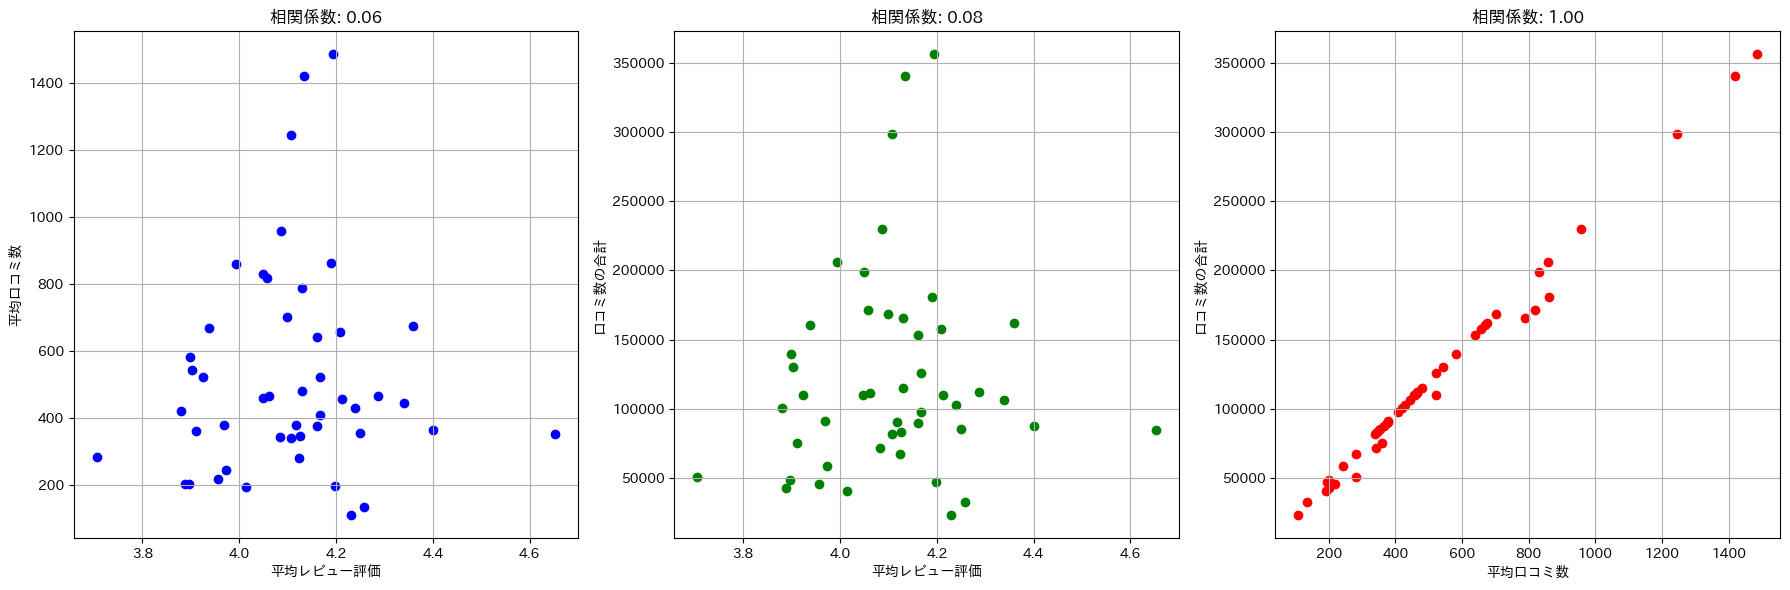

In [52]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# SQLiteデータベースに接続
conn = sqlite3.connect('jalan_db.db')
cursor = conn.cursor()

# 都道府県ごとの平均レビュー評価、口コミ数の平均、口コミ数の合計を計算
cursor.execute('''
SELECT prefecture_name, 
       AVG(CAST(review AS REAL)) AS avg_review, 
       AVG(CAST(comment_counts AS REAL)) AS avg_comment_count,
       SUM(CAST(comment_counts AS INTEGER)) AS total_comment_count
FROM jalan_pre_data
GROUP BY prefecture_name
ORDER BY avg_review DESC
''')

# 結果を取得
rows = cursor.fetchall()

# データを処理
prefecture_names = [row[0] for row in rows]
avg_reviews = [row[1] for row in rows]
avg_comment_counts = [row[2] for row in rows]
total_comment_counts = [row[3] for row in rows]

# データベース接続を閉じる
conn.close()

# print関数でデータを表示
print("都道府県ごとの平均レビュー評価、平均口コミ数、口コミ数の合計:")
for i in range(len(prefecture_names)):
    print(f"{prefecture_names[i]}: 平均レビュー評価 = {avg_reviews[i]}, "
          f"平均口コミ数 = {avg_comment_counts[i]}, 口コミ数の合計 = {total_comment_counts[i]}")

# 相関係数の計算
# 各ペアのデータをnumpyの配列に変換
reviews_array = np.array(avg_reviews)
comments_array = np.array(avg_comment_counts)
total_comments_array = np.array(total_comment_counts)

# 相関係数の計算
corr_reviews_comments = np.corrcoef(reviews_array, comments_array)[0, 1]
corr_reviews_total_comments = np.corrcoef(reviews_array, total_comments_array)[0, 1]
corr_comments_total_comments = np.corrcoef(comments_array, total_comments_array)[0, 1]

# 相関係数を表示
print(f"平均レビュー評価と平均口コミ数の相関係数: {corr_reviews_comments:.2f}")
print(f"平均レビュー評価と口コミ数の合計の相関係数: {corr_reviews_total_comments:.2f}")
print(f"平均口コミ数と口コミ数の合計の相関係数: {corr_comments_total_comments:.2f}")

# グラフの作成
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. 平均レビュー評価と平均口コミ数
axes[0].scatter(reviews_array, comments_array, color='b')
axes[0].set_xlabel('平均レビュー評価')
axes[0].set_ylabel('平均口コミ数')
axes[0].set_title(f'相関係数: {corr_reviews_comments:.2f}')
axes[0].grid(True)

# 2. 平均レビュー評価と口コミ数の合計
axes[1].scatter(reviews_array, total_comments_array, color='g')
axes[1].set_xlabel('平均レビュー評価')
axes[1].set_ylabel('口コミ数の合計')
axes[1].set_title(f'相関係数: {corr_reviews_total_comments:.2f}')
axes[1].grid(True)

# 3. 平均口コミ数と口コミ数の合計
axes[2].scatter(comments_array, total_comments_array, color='r')
axes[2].set_xlabel('平均口コミ数')
axes[2].set_ylabel('口コミ数の合計')
axes[2].set_title(f'相関係数: {corr_comments_total_comments:.2f}')
axes[2].grid(True)

# グラフを表示
plt.tight_layout()
plt.show()
